In [317]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import random
from collections import Counter
import sys
%matplotlib inline

In [318]:
CITY_POPULATION = 10000
MEAN_NETWORK_DEGREE = 50
MEAN_INTERACTIONS_PER_DAY = 10
TRANSMISSION_RATE = 3.0/100
ILLNESS_LENGTH_DAYS = 14
SYMPTOMATIC_RATE = 0.5


The city graph is generated using the Watts–Strogatz model (https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model)

In [319]:
BETA = 0.5 # a parameter for the model - read wiki page

In [320]:

city_social_network = nx.watts_strogatz_graph(CITY_POPULATION, MEAN_NETWORK_DEGREE, BETA)


<BarContainer object of 33 artists>

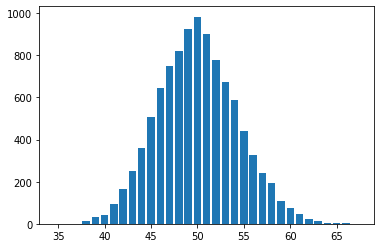

In [321]:
degrees = dict(city_social_network.degree()).values()
degree_counts = np.unique(list(degrees), return_counts = True)
degree_counts
plt.bar(degree_counts[0], degree_counts[1]) 


Generating an Age probability distribution function-

Based on 2000 Census data (https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf)

In [322]:
age_group_numbers_USA = [19175798,20549505,20528072,20219890,18964001,19381336,20510388,22706664,22441863, 20092404,17585548,13469237, 10805447,9533545,8857441,7415813,4945367,2789818,1112531,286784,50454,]

Each age group is of 5 years - under 5yo, 5-10, 10-15 .... 95-100, >100

For convenience, we choose a representative age for each group

<BarContainer object of 21 artists>

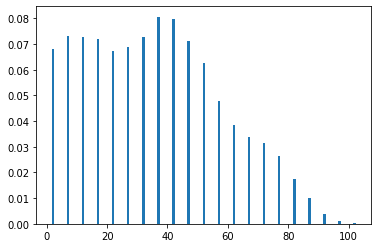

In [323]:
age_group_ratios = np.array(age_group_numbers_USA)/sum(age_group_numbers_USA)
ages = [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 102]
plt.bar(ages, age_group_ratios)

Assigning an age to each person in our city

In [324]:
city_ages = np.random.choice(ages, CITY_POPULATION, p = age_group_ratios)

<BarContainer object of 21 artists>

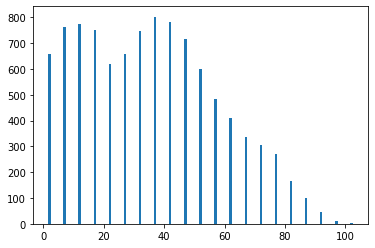

In [325]:
age_dist = np.unique(city_ages, return_counts = True)
plt.bar(age_dist[0], age_dist[1])

In [326]:
for i in range(CITY_POPULATION):
    city_social_network.nodes[i]['age'] = city_ages[i]
    city_social_network.nodes[i]['infected'] = False
    city_social_network.nodes[i]['alive'] = True
    city_social_network.nodes[i]['isolated'] = False
    city_social_network.nodes[i]['infected_date'] = sys.maxsize
    city_social_network.nodes[i]['recovered'] = False
    
    

In [327]:
city_social_network.nodes[0]

{'age': 7,
 'infected': False,
 'alive': True,
 'isolated': False,
 'infected_date': 9223372036854775807,
 'recovered': False}

In [336]:
def mortality_pdf(age):
    
    return ((age-102)/1020 +0.1)

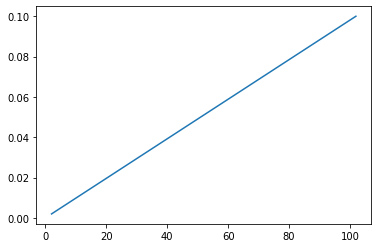

In [337]:
plt.plot(ages,[mortality_pdf(age) for age in ages])

In [338]:
def get_disease_stats(city_graph):
    total_infected = 0
    total_dead = 0
    total_healthy = 0
    total_recovered = 0
    for i in city_graph.nodes():
        if not city_social_network.nodes[i]['alive']:
            total_dead+=1
        #dead people are not infected
        elif city_social_network.nodes[i]['infected']:
            total_infected +=1
        elif city_social_network.nodes[i]['recovered']:
            total_recovered +=1
        
        else:
            total_healthy+=1
        
    return{'infected':total_infected, 'dead': total_dead, 'never infected':total_healthy, 'recovered': total_recovered}
        
        

In [339]:
get_disease_stats(city_social_network)

{'infected': 0, 'dead': 0, 'never infected': 10000, 'recovered': 0}

In [340]:
def get_daily_visits_no_preventative_measures(city_graph):
    total_visits_in_day = (len(city_graph.nodes)*MEAN_INTERACTIONS_PER_DAY)/2 # Two people take part in an interaction
    day_visits = random.sample(list(city_graph.edges), int(total_visits_in_day))
    return day_visits
    

Distribution of Interactions on Day 0 (by person):

In [341]:
day_0_interactions = get_daily_visits(city_social_network)
interactions_per_person = Counter()
for interaction in day_0_interactions:
    interactions_per_person[interaction[0]]+=1
    interactions_per_person[interaction[1]]++1
    

<BarContainer object of 17 artists>

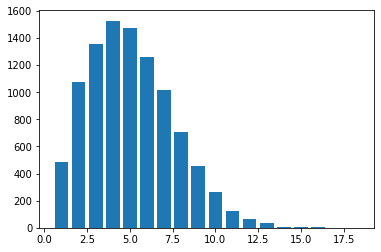

In [342]:
hist = np.unique(list(interactions_per_person.values()), return_counts = True)
plt.bar(hist[0],hist[1])

In [343]:
def simulate_single_day(city_graph, day_number):
    interactions = get_daily_visits_no_preventative_measures(city_graph)
    for p1,p2 in interactions:
        if not city_graph.nodes[p1]['alive'] or not city_graph.nodes[p1]['alive']:
            continue
        if city_graph.nodes[p1]['infected'] and city_graph.nodes[p2]['infected']:
            continue
        if city_graph.nodes[p1]['recovered'] or city_graph.nodes[p2]['recovered']:
            continue
        if not city_graph.nodes[p1]['infected'] and not city_graph.nodes[p2]['infected']:
            continue
        # one of the people is infected.
        if random.uniform(0, 1) < TRANSMISSION_RATE:
            #infect!
            if not city_graph.nodes[p1]['infected']:
                if city_graph.nodes[p2]['infected_date'] == day_number:
                    continue
                city_graph.nodes[p1]['infected'] = True
                city_graph.nodes[p1]['infected_date'] = day_number
            else:
                if city_graph.nodes[p1]['infected_date'] == day_number:
                    continue
                city_graph.nodes[p2]['infected'] = True
                city_graph.nodes[p2]['infected_date'] = day_number
    for p in city_graph.nodes():
        if day_number - city_graph.nodes[p]['infected_date'] == ILLNESS_LENGTH_DAYS:
            if random.uniform(0, 1) < mortality_pdf(city_graph.nodes[p]['age']) :
                city_graph.nodes[p]['alive'] = False
            else:
                city_graph.nodes[p]['recovered'] = True
                city_graph.nodes[p]['infected'] = False
    
                
        
                
            
            
            

        
    

In [344]:
daily_stats = []
city_social_network.nodes[0]['infected'] = True
city_social_network.nodes[0]['infected_date'] = 0
total_infections = 1
i=0
while total_infections>0:
    print('day:'+str(i))
    simulate_single_day(city_social_network,i)
    daily_stats.append(get_disease_stats(city_social_network))
    print(daily_stats[-1])
    total_infections = daily_stats[-1]['infected']
    i+=1

day:0
{'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0}
day:1
{'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0}
day:2
{'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0}
day:3
{'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0}
day:4
{'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0}
day:5
{'infected': 4, 'dead': 0, 'never infected': 9996, 'recovered': 0}
day:6
{'infected': 5, 'dead': 0, 'never infected': 9995, 'recovered': 0}
day:7
{'infected': 5, 'dead': 0, 'never infected': 9995, 'recovered': 0}
day:8
{'infected': 9, 'dead': 0, 'never infected': 9991, 'recovered': 0}
day:9
{'infected': 11, 'dead': 0, 'never infected': 9989, 'recovered': 0}
day:10
{'infected': 12, 'dead': 0, 'never infected': 9988, 'recovered': 0}
day:11
{'infected': 18, 'dead': 0, 'never infected': 9982, 'recovered': 0}
day:12
{'infected': 23, 'dead': 0, 'never infected': 9977, 'recovered': 0}
day:13
{'infected': 29, 'dead': 0, 'never in

{'infected': 3, 'dead': 334, 'never infected': 132, 'recovered': 9531}
day:106
{'infected': 3, 'dead': 334, 'never infected': 132, 'recovered': 9531}
day:107
{'infected': 4, 'dead': 334, 'never infected': 131, 'recovered': 9531}
day:108
{'infected': 4, 'dead': 334, 'never infected': 131, 'recovered': 9531}
day:109
{'infected': 5, 'dead': 334, 'never infected': 130, 'recovered': 9531}
day:110
{'infected': 4, 'dead': 334, 'never infected': 130, 'recovered': 9532}
day:111
{'infected': 6, 'dead': 334, 'never infected': 128, 'recovered': 9532}
day:112
{'infected': 6, 'dead': 334, 'never infected': 128, 'recovered': 9532}
day:113
{'infected': 6, 'dead': 334, 'never infected': 128, 'recovered': 9532}
day:114
{'infected': 8, 'dead': 334, 'never infected': 126, 'recovered': 9532}
day:115
{'infected': 7, 'dead': 334, 'never infected': 126, 'recovered': 9533}
day:116
{'infected': 7, 'dead': 334, 'never infected': 126, 'recovered': 9533}
day:117
{'infected': 7, 'dead': 334, 'never infected': 126, 

{'infected': 2, 'dead': 336, 'never infected': 93, 'recovered': 9569}
day:211
{'infected': 2, 'dead': 336, 'never infected': 93, 'recovered': 9569}
day:212
{'infected': 2, 'dead': 336, 'never infected': 93, 'recovered': 9569}
day:213
{'infected': 1, 'dead': 336, 'never infected': 93, 'recovered': 9570}
day:214
{'infected': 2, 'dead': 336, 'never infected': 92, 'recovered': 9570}
day:215
{'infected': 3, 'dead': 336, 'never infected': 91, 'recovered': 9570}
day:216
{'infected': 3, 'dead': 336, 'never infected': 91, 'recovered': 9570}
day:217
{'infected': 3, 'dead': 336, 'never infected': 90, 'recovered': 9571}
day:218
{'infected': 4, 'dead': 336, 'never infected': 89, 'recovered': 9571}
day:219
{'infected': 4, 'dead': 336, 'never infected': 89, 'recovered': 9571}
day:220
{'infected': 4, 'dead': 336, 'never infected': 89, 'recovered': 9571}
day:221
{'infected': 5, 'dead': 336, 'never infected': 88, 'recovered': 9571}
day:222
{'infected': 5, 'dead': 336, 'never infected': 88, 'recovered': 

In [118]:
get_disease_stats(city_social_network)

{'infected': 0, 'dead': 0, 'healthy': 10000}